In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from extreme_deconvolution import extreme_deconvolution 

In [3]:
from sklearn.datasets import make_blobs

### Support func

In [4]:
def cov_ellipse(mean, cov,**kwargs):
    """
    x,y = center of ellipse
    sx, sy = standard deviation in x and y
    rxy = correlation between sx and sy; such that cov(x,y) = rxy * sx * sy
    
    
    Source:
    https://cookierobotics.com/007/
    """

    from matplotlib.patches import Ellipse
    from math import sqrt, atan2, degrees
    
    x,y = mean
    a, b, _, c = cov.ravel()
   
    l1 = sqrt((a+c)/2 + sqrt((a/2-c/2)**2 + b**2))
    l2 = sqrt((a+c)/2 - sqrt((a/2-c/2)**2 + b**2))
    angle = 0 if (b==0 and a>=c) else (90 if b==0 and a<c else degrees(atan2(l1**2-a,b)))
    return Ellipse(xy=(x,y),
                width=l1*2, height=l2*2,
                angle=angle, **kwargs)
                

### Generating some random blobs

(3001, 2)
[ 2.30571951 -4.37909386]
[-7.45803335 -3.68275895]
[ 9.94250748 -1.54524058]


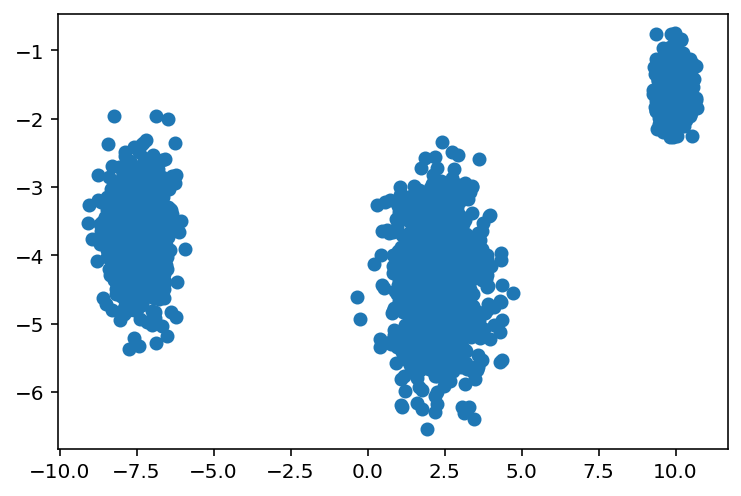

In [5]:
rng = np.random.RandomState(315)

data, labels = make_blobs(n_samples=3001, n_features=2, random_state=rng, centers=3, cluster_std = [0.75,0.5,0.25])


print(data.shape)

if data.shape[1] ==2:
    plt.scatter(data[:,0],data[:,1])
if data.shape[1] ==1:
    plt.hist(data, bins=100)
    
for label in set(labels):
    print(data[labels==label].mean(axis=0))

In [6]:
### Make blobs blobbier (convolve with additional uncertainties)

In [7]:
ndata, dim = data.shape

# Convolve data with uncertainties
noise_var = rng.uniform(size=(ndata,dim))/2.
noise_cor = np.product(np.sqrt(noise_var), axis=1) * -1 # rng.uniform(low=-1., high=1., size=ndata)
I2 = np.eye(2)
cov =  np.array([-(I2-1)*noise_cor[i] + I2*noise_var[i] for i in range(ndata)])


ydata = np.array([rng.multivariate_normal(data[i], cov[i]).tolist() for i in range(ndata)])
ycovar = cov

In [8]:

from sklearn.mixture import GaussianMixture


def initial_guess_from_GMM(X, n_components=2, random_state=0):
    GMM = GaussianMixture(n_components=n_components, random_state=random_state)
    GM = GMM.fit(X)
    return (GM.means_, GM.covariances_)

In [9]:
def XD_ND_Ncomp(data, covar, n_components:int=3, print_init=False, plot=True):
    """
    Input:
    data: (ndata, ndim) 
    covar: (ndata, ndim, ndim)
    
    n_components: number of components to fit
    
    """
    
    ### initialize fit with GMM
    K= n_components
    initamp= np.ones(K)/float(K)
    initmean, initcovar = initial_guess_from_GMM(data,n_components)
        
    if print_init:
        print('initial')
        print('initamp: ',initamp)
        print('initmean: ',initmean)
        print('initcovar: ',initcovar)
        print()

        
        print('ydata.shape: ', ydata.shape)
        print('ycovar.shape: ', ycovar.shape)
        print('initamp.shape: ', initamp.shape)
        print('initmean.shape: ', initmean.shape)
        print('initcovar.shape: ', initcovar.shape)
        print()
        
    # Running XD
    extreme_deconvolution(data,covar,initamp,initmean,initcovar,maxsnm=True)
   
    print('XD - fit')        
    print('amp: ',initamp)
    print('mean: ',initmean)
    print('cov:',initcovar)
    
    if plot:
        # Plotting the results
        plt.scatter(data[:,0], data[:,1])

        for comp in initmean:
            plt.scatter(*comp, c='r')
    
    return initamp, initmean, initcovar

    

        


XD - fit
amp:  [0.33355548 0.33322226 0.33322226]
mean:  [[ 2.30624743 -4.38298507]
 [-7.43125258 -3.71473645]
 [ 9.93778157 -1.53636569]]
cov: [[[ 0.56237966 -0.01708008]
  [-0.01708008  0.52732649]]

 [[ 0.24641807 -0.01615504]
  [-0.01615504  0.28004848]]

 [[ 0.05305946  0.00725499]
  [ 0.00725499  0.05053928]]]


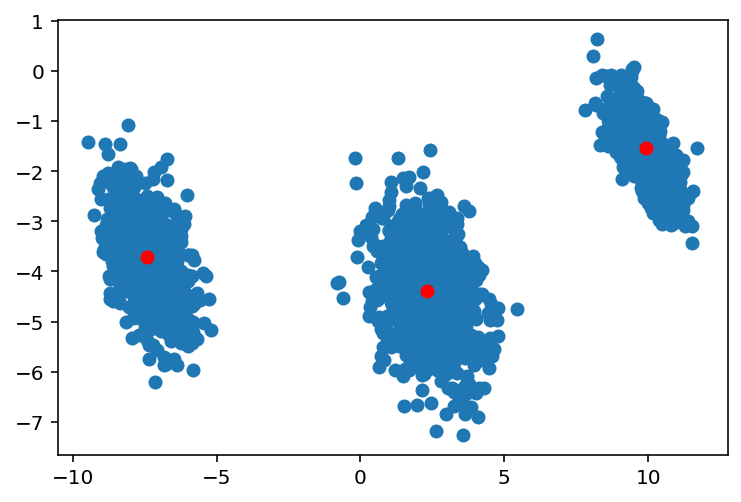

In [10]:
amp, mean, covar = XD_ND_Ncomp(ydata, ycovar)

In [11]:
### Verifying with the true blobs

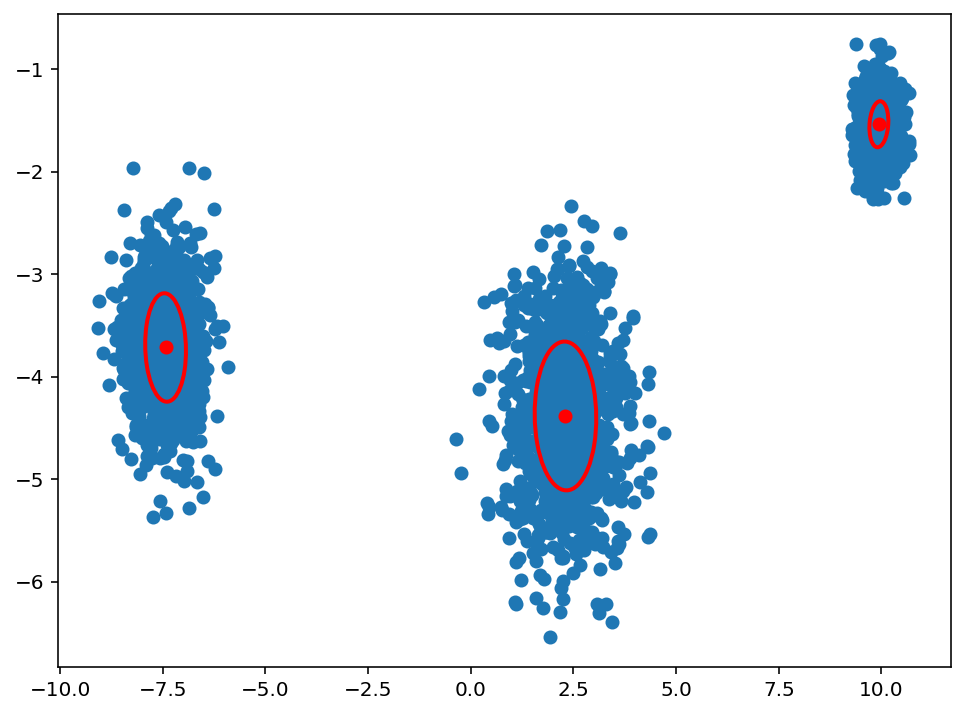

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(data[:,0], data[:,1])

for _mean, _cov in zip(mean, covar):
    plt.scatter(*_mean, c='r', zorder=10)
    
    ell = cov_ellipse(_mean, _cov, edgecolor='r', lw=2)
    ax.add_artist(ell)